In [385]:
from datetime import datetime
import numpy as np             
import pandas as pd            
import matplotlib.pylab as plt 
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
import seaborn as sns

# Опис вхідних даних

In [351]:
# опис даних, є дві колонки - дата, к-сть пасажирів за місяць. Всього є 144 рядка. Дані взяті за 11 років. 

In [386]:
df = pd.read_csv('AirPassengers.csv',sep = ',')
df['Month'] = pd.to_datetime(df['Month'],infer_datetime_format=True)
df.columns = ['date','pass']

In [387]:
indexedDataset = df.set_index(['date'])
indexedDataset.head(5)

,pass
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


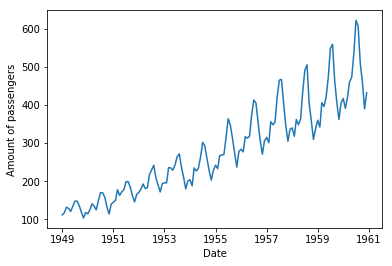

In [388]:
## plot data as time series
plt.xlabel('Date')
plt.ylabel('Amount of passengers')
plt.plot(indexedDataset)

In [389]:
df.set_index('date', inplace=True)

# Розкладаємо часовий ряд за multiplicative та additive методами

In [390]:
result_mul = seasonal_decompose(df['pass'], model='multiplicative', extrapolate_trend='freq')
result_add = seasonal_decompose(df['pass'], model='additive', extrapolate_trend='freq')

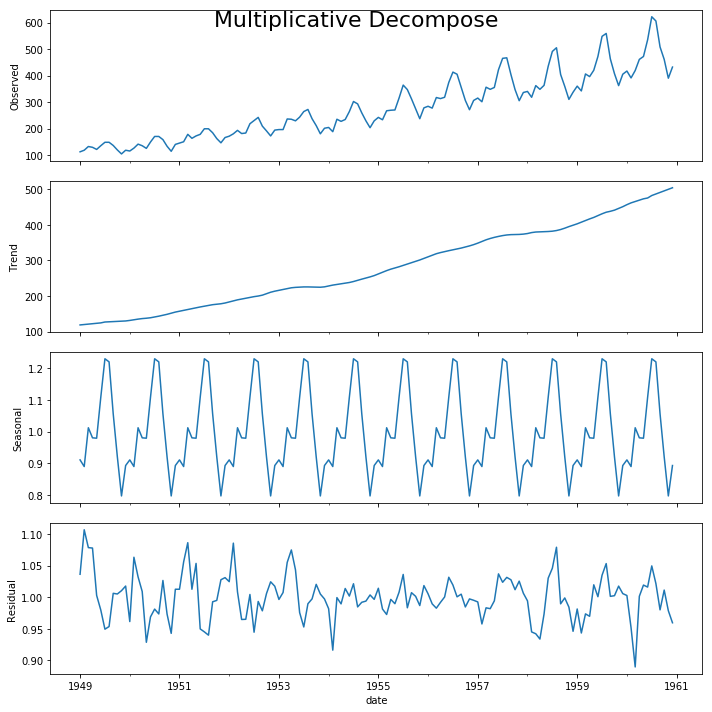

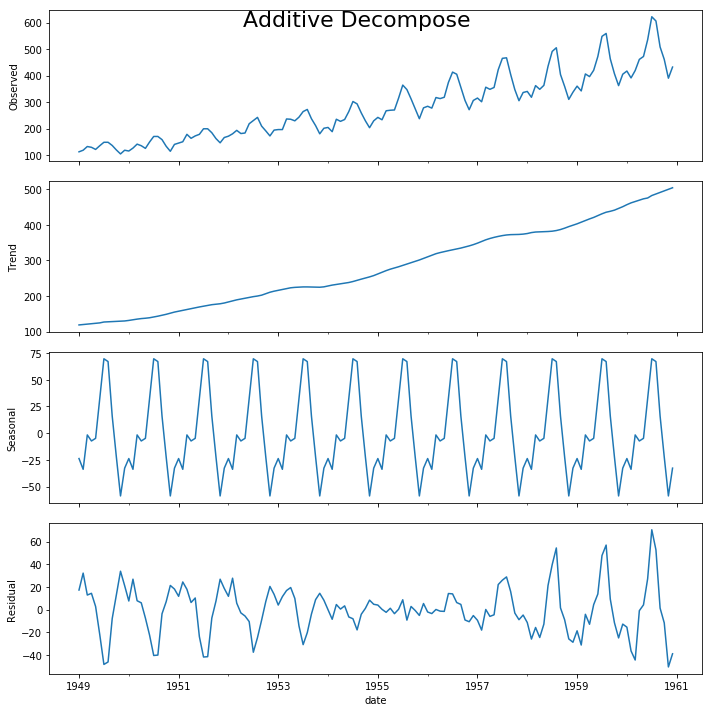

In [391]:
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

# на графіках вище видно, що спостерігається сезонність та чіткий тренд - з кожним роком стає все більше пасажирів

# Виясняємо, чи є ряд стаціонарним

In [392]:
# Визначаємо середнє та дисперсію за кожний рік
rolmean = df.rolling(window=12).mean()
rolstd = df.rolling(window=12).std()

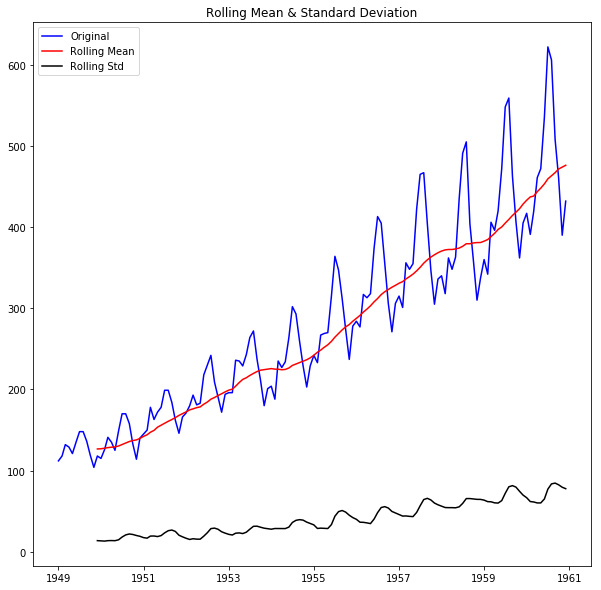

In [393]:
# Накладаємо сережнє та дисперсію на графік
orig = plt.plot(df, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [364]:
# Висновок: для того, щоб ряд був стаціонарним середнє та дисперсія не має залежати від часу, та бути +- паралельна осі x.
# З першого погляду наш ряд не є стаціонарним. Проведемо ADCF тест, для того, щоб переконатися в нестаціонарності ряду.

In [394]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['pass'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [49]:
# Тест підтвердив, що ряд є нестаціонарним(p-value дуже велике)

# Трансформує ряд, щоб він став стаціонарний

In [412]:
# Логарифмічна функція
indexedDataset_logScale = np.log(df)
# plt.plot(indexedDataset_logScale)

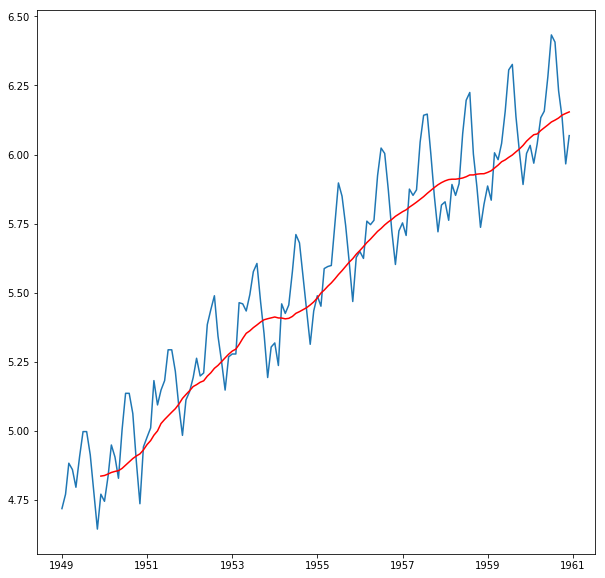

In [413]:
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')
# plt.plot(movingSTD, color='black')

In [ ]:
# вже краще, середнє рухається від 4.75 до 6.25. Без застосування логарифмічної функції середнє рухалося від 100 до 400.

In [396]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)

In [56]:
# віднімемо середнє, для того, щоб позбутися тренду і створити ряд без тренду

In [414]:
# допоміжна функція
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['pass'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

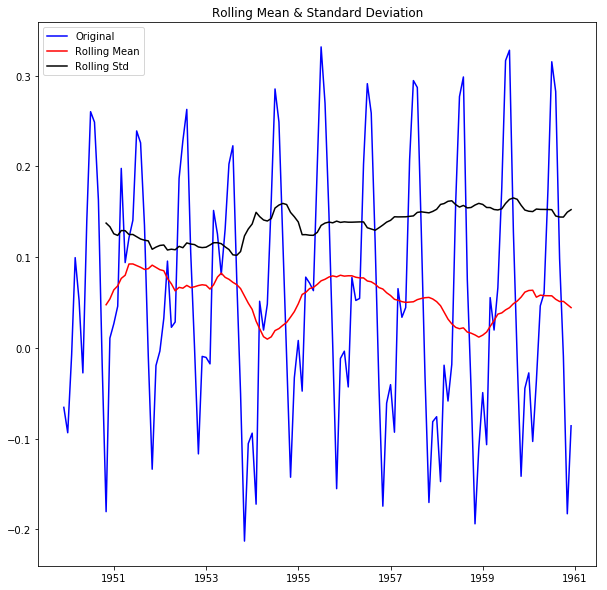

Results of Dickey Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [415]:
test_stationarity(datasetLogScaleMinusMovingAverage)

In [416]:
# p - value зменшилося до 0.02, що впринципі вже достатньо для того, щоб стверджувати, що ряд є стаціонарним.
# Спробуємо тепер застосувати експоненціальне перетворення

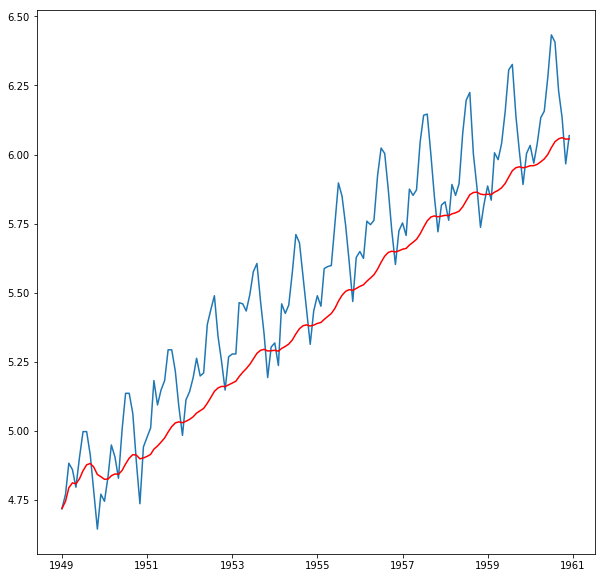

In [399]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

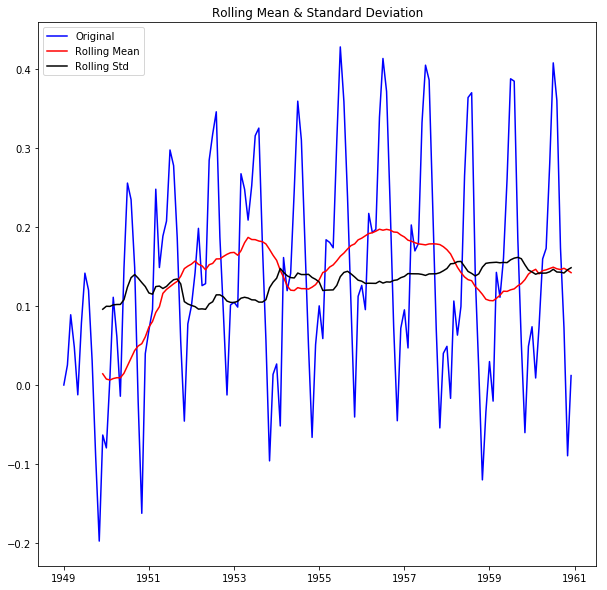

Results of Dickey Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [400]:
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)


In [ ]:
# p-value зменшилося до 0.005. І середнє та дисперсія майже паралельні осі x. Відхиляються від (0 до 0.1).
# В результаті ми отримали стаціонарний ряд
# спробуємо time-shift метод трансформації

In [417]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()

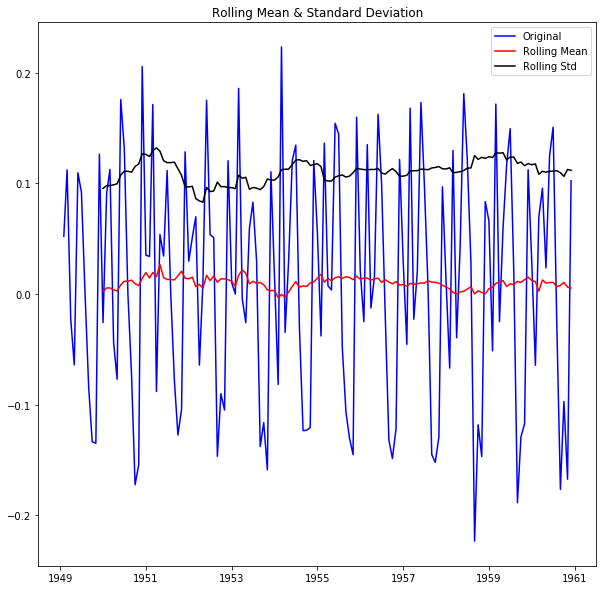

Results of Dickey Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [418]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)


In [420]:
# p-value стало тепер 0.07

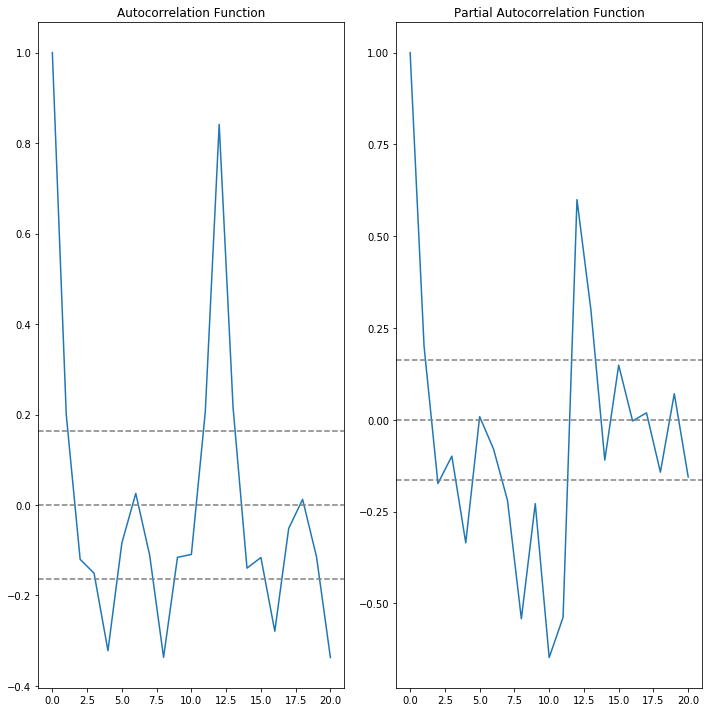

In [419]:
# Автокореляційна функція 

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()

In [72]:
# з ACF видно, що в точці х=2 графік перетинає вісь у. Тому для ARIMA модель параметр Q = 2. Також видно періодичність з ACF.
# з PACF видно, що в точці х=2 графік перетинає вісь у. Тому для ARIMA модель параметр P = 2

# Побудова моделей

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting AR model


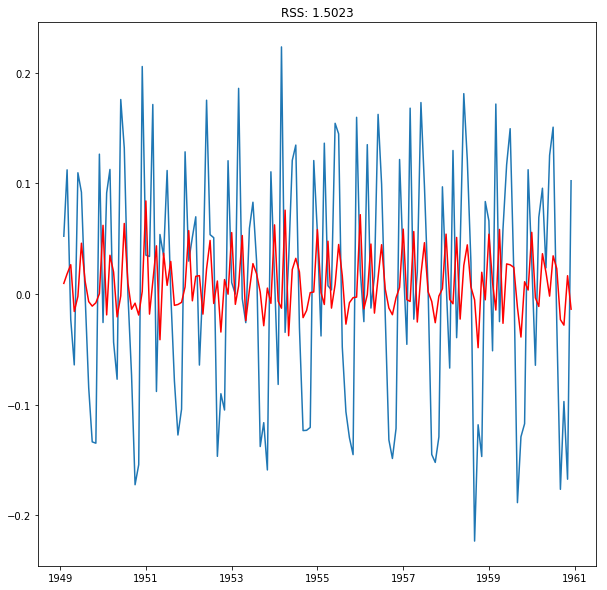

In [421]:
#AR Model
model = ARIMA(indexedDataset_logScale, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['pass'])**2))
print('Plotting AR model')

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting MA model


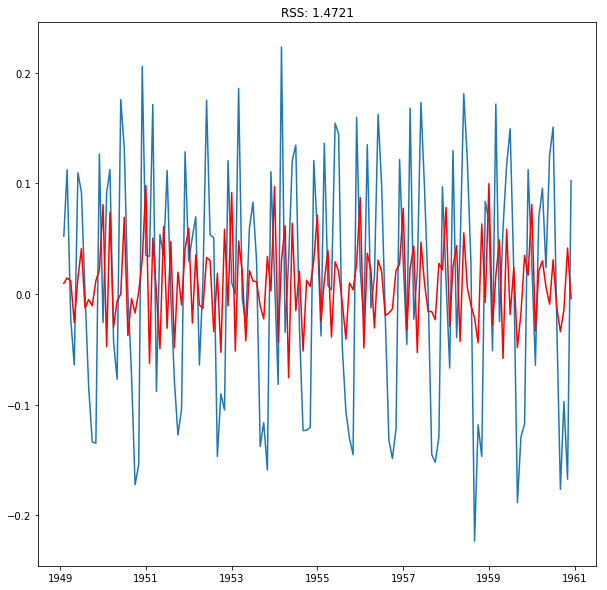

In [422]:
#MA Model
model = ARIMA(indexedDataset_logScale, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - datasetLogDiffShifting['pass'])**2))
print('Plotting MA model')

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting ARIMA model


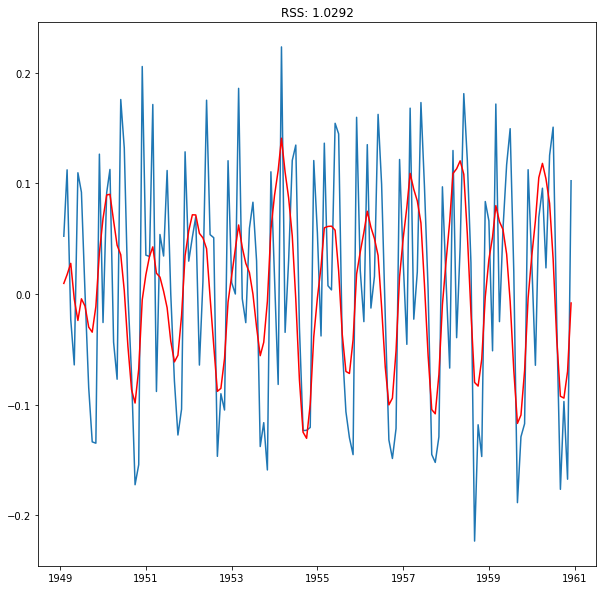

In [423]:
# AR+I+MA = ARIMA model
model = ARIMA(indexedDataset_logScale, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting['pass'])**2))
print('Plotting ARIMA model')

In [426]:
# результати
pd.DataFrame({'Метод':['AR','MA','ARIMA'],'rss_error':[1.5023,1.4721,1.0292]}).set_index('Метод')

,rss_error
Метод,
AR,1.5023
MA,1.4721
ARIMA,1.0292


In [81]:
# ARIMA показала найкращий результат. Тепер ми можемо використовувати цю модель для передбачення.  

# Прогнозування

In [427]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

date
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [408]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

In [428]:
# потрібно вернутися до початкової шкали
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['pass'].iloc[0], index=indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

date
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

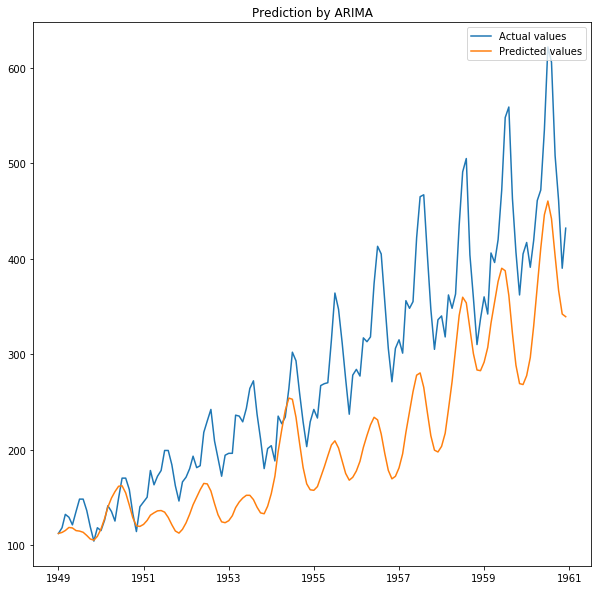

In [441]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.title('Prediction by ARIMA')
plt.plot(predictions_ARIMA)
plt.legend(('Actual values','Predicted values'),loc='upper right')



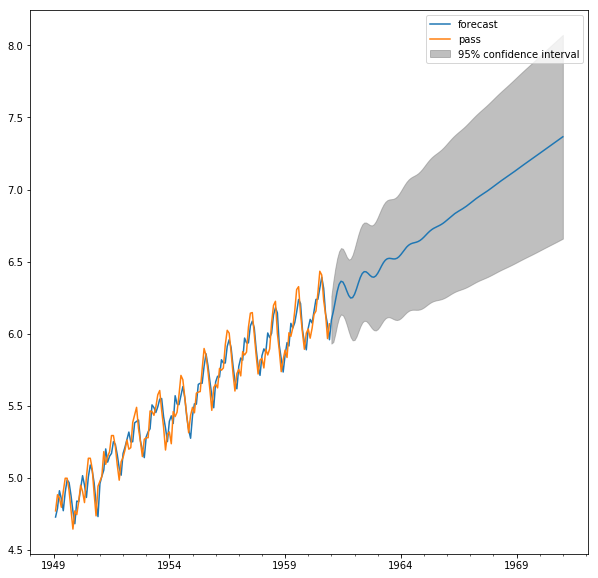

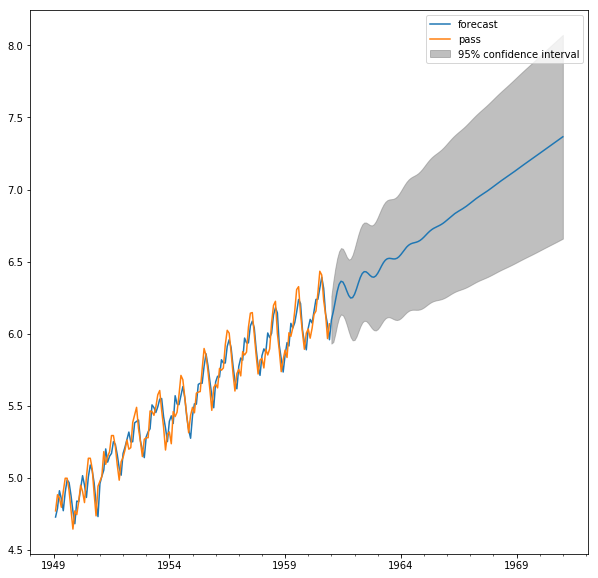

In [442]:
# Передбачення на 120 точок
results_ARIMA.plot_predict(1,264) 

Отже, модель ARIMA досить точно передбачає к-сть пасажирів.